## Crypto Prediction with LSTM: BitCoin (BTC) 

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .92 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-09-18 21:02:51.644001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull BTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-19T00:00:00.0000000Z', 'time_period_end': '2023-09-20T00:00:00.0000000Z', 'time_open': '2023-09-19T00:00:46.8100000Z', 'time_close': '2023-09-19T01:03:54.8130000Z', 'price_open': 26766, 'price_high': 26789, 'price_low': 26682, 'price_close': 26684, 'volume_traded': 27.52560752, 'trades_count': 481}, {'time_period_start': '2023-09-18T00:00:00.0000000Z', 'time_period_end': '2023-09-19T00:00:00.0000000Z', 'time_open': '2023-09-18T00:00:10.5790000Z', 'time_close': '2023-09-18T23:59:38.3520000Z', 'price_open': 26533, 'price_high': 27421, 'price_low': 26382, 'price_close': 26770, 'volume_traded': 1942.69872335, 'trades_count': 13118}, {'time_period_start': '2023-09-17T00:00:00.0000000Z', 'time_period_end': '2023-09-18T00:00:00.0000000Z', 'time_open': '2023-09-17T00:00:28.1100000Z', 'time_close': '2023-09-17T23:59:20.7440000Z', 'price_open': 26571, 'price_high': 26618, 'price_low': 26414, 'price_close': 26535, 'volume_traded': 529.80823767, 'trades_count': 7247

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-19T00:00:00.0000000Z,2023-09-20T00:00:00.0000000Z,2023-09-19T00:00:46.8100000Z,2023-09-19T01:03:54.8130000Z,26766.0,26789.0,26682.0,26684.0,27.525608,481
1,2023-09-18T00:00:00.0000000Z,2023-09-19T00:00:00.0000000Z,2023-09-18T00:00:10.5790000Z,2023-09-18T23:59:38.3520000Z,26533.0,27421.0,26382.0,26770.0,1942.698723,13118
2,2023-09-17T00:00:00.0000000Z,2023-09-18T00:00:00.0000000Z,2023-09-17T00:00:28.1100000Z,2023-09-17T23:59:20.7440000Z,26571.0,26618.0,26414.0,26535.0,529.808238,7247
3,2023-09-16T00:00:00.0000000Z,2023-09-17T00:00:00.0000000Z,2023-09-16T00:00:06.6310000Z,2023-09-16T23:59:36.1270000Z,26609.0,26767.0,26459.0,26571.0,602.340303,7658
4,2023-09-15T00:00:00.0000000Z,2023-09-16T00:00:00.0000000Z,2023-09-15T00:00:32.9490000Z,2023-09-15T23:59:45.8940000Z,26529.0,26878.0,26228.0,26607.0,1379.105636,11902


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


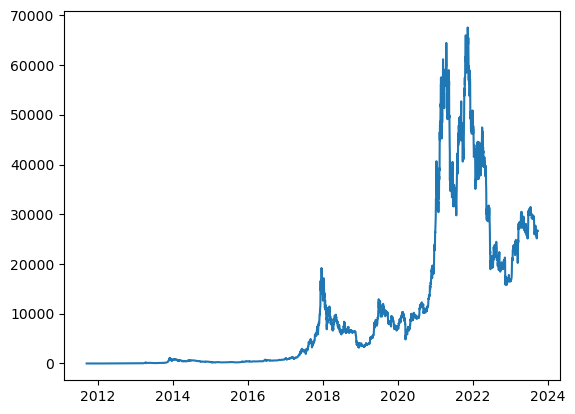

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale Data
log_transformed_data = np.log(shifted_df_as_np)



# Split key from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4207, 30), (4207,), (4207,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3365, 30), (3365,), (421, 30), (421,), (421, 30), (421,))

In [10]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.Bidirectional(LSTM(64)),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-18 21:05:18.866370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
106/106 [==============================] - 7s 31ms/step - loss: 4.6956 - mean_absolute_error: 1.1304 - val_loss: 0.0306 - val_mean_absolute_error: 0.1420
Epoch 2/100
106/106 [==============================] - 2s 22ms/step - loss: 0.0194 - mean_absolute_error: 0.1000 - val_loss: 0.0145 - val_mean_absolute_error: 0.0976
Epoch 3/100
106/106 [==============================] - 2s 23ms/step - loss: 0.0149 - mean_absolute_error: 0.0862 - val_loss: 0.0333 - val_mean_absolute_error: 0.1550
Epoch 4/100
106/106 [==============================] - 2s 22ms/step - loss: 0.0140 - mean_absolute_error: 0.0852 - val_loss: 0.0155 - val_mean_absolute_error: 0.1030
Epoch 5/100
106/106 [==============================] - 2s 22ms/step - loss: 0.0117 - mean_absolute_error: 0.0778 - val_loss: 0.0153 - val_mean_absolute_error: 0.1016
Epoch 6/100
106/106 [==============================] - 2s 22ms/step - loss: 0.0099 - mean_absolute_error: 0.0702 - val_loss: 0.0350 - val_mean_absolute_error: 0.1635
Epoc

106/106 [==============================] - 2s 22ms/step - loss: 0.0050 - mean_absolute_error: 0.0533 - val_loss: 0.0036 - val_mean_absolute_error: 0.0491
Epoch 51/100
106/106 [==============================] - 2s 22ms/step - loss: 0.0037 - mean_absolute_error: 0.0433 - val_loss: 0.0056 - val_mean_absolute_error: 0.0644
Epoch 52/100
106/106 [==============================] - 2s 22ms/step - loss: 0.0039 - mean_absolute_error: 0.0432 - val_loss: 0.0120 - val_mean_absolute_error: 0.1025
Epoch 53/100
106/106 [==============================] - 2s 21ms/step - loss: 0.0038 - mean_absolute_error: 0.0431 - val_loss: 0.0144 - val_mean_absolute_error: 0.1137
Epoch 54/100
106/106 [==============================] - 2s 22ms/step - loss: 0.0041 - mean_absolute_error: 0.0451 - val_loss: 0.0085 - val_mean_absolute_error: 0.0823
Epoch 55/100
106/106 [==============================] - 3s 26ms/step - loss: 0.0034 - mean_absolute_error: 0.0409 - val_loss: 0.0109 - val_mean_absolute_error: 0.0961
Epoch 56/10

106/106 [==============================] - 2s 23ms/step - loss: 0.0033 - mean_absolute_error: 0.0394 - val_loss: 0.0021 - val_mean_absolute_error: 0.0354
Epoch 100/100
106/106 [==============================] - 2s 22ms/step - loss: 0.0031 - mean_absolute_error: 0.0380 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302


106/106 [==============================] - 2s 11ms/step


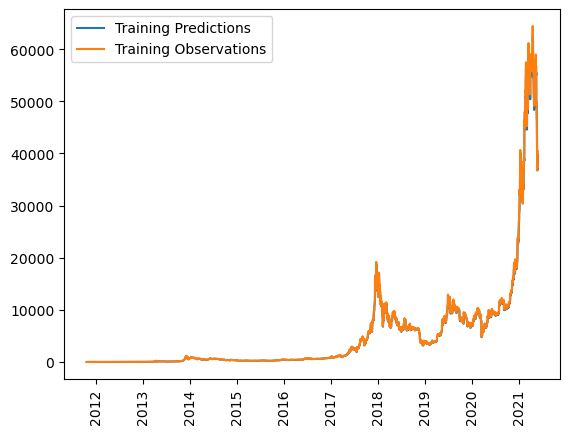

In [11]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [12]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.001551525667309761
Val MAE: 0.03019525855779648


14/14 [==============================] - 0s 8ms/step


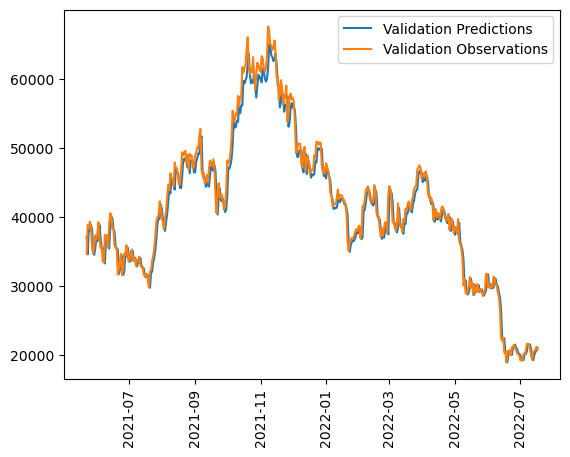

In [13]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [14]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0007271050708368421
Test MAE: 0.017439821735024452


14/14 [==============================] - 0s 8ms/step


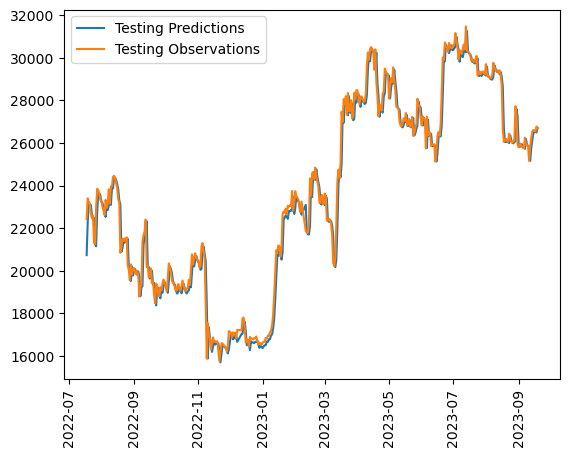

In [15]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [16]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9807852838217598


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [19]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [20]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1641,),
 (1641, 30),
 (1641,),
 (252,),
 (252, 30),
 (252,),
 (211,),
 (211, 30),
 (211,))

In [17]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.Bidirectional(LSTM(64)),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
106/106 [==============================] - 9s 32ms/step - loss: 39.2265 - mean_absolute_error: 5.7958 - val_loss: 71.1687 - val_mean_absolute_error: 8.4314
Epoch 2/300
106/106 [==============================] - 2s 22ms/step - loss: 14.8981 - mean_absolute_error: 3.2774 - val_loss: 21.9707 - val_mean_absolute_error: 4.6784
Epoch 3/300
106/106 [==============================] - 2s 22ms/step - loss: 1.8574 - mean_absolute_error: 0.9179 - val_loss: 4.4464 - val_mean_absolute_error: 2.0893
Epoch 4/300
106/106 [==============================] - 2s 23ms/step - loss: 0.1985 - mean_absolute_error: 0.2392 - val_loss: 1.6798 - val_mean_absolute_error: 1.2650
Epoch 5/300
106/106 [==============================] - 2s 22ms/step - loss: 0.0950 - mean_absolute_error: 0.1663 - val_loss: 0.8272 - val_mean_absolute_error: 0.8664
Epoch 6/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0598 - mean_absolute_error: 0.1464 - val_loss: 0.3739 - val_mean_absolute_error: 0.5598


106/106 [==============================] - 3s 25ms/step - loss: 0.0063 - mean_absolute_error: 0.0538 - val_loss: 0.0194 - val_mean_absolute_error: 0.1166
Epoch 51/300
106/106 [==============================] - 2s 22ms/step - loss: 0.0062 - mean_absolute_error: 0.0537 - val_loss: 0.0158 - val_mean_absolute_error: 0.1038
Epoch 52/300
106/106 [==============================] - 2s 21ms/step - loss: 0.0064 - mean_absolute_error: 0.0554 - val_loss: 0.0216 - val_mean_absolute_error: 0.1238
Epoch 53/300
106/106 [==============================] - 4s 39ms/step - loss: 0.0060 - mean_absolute_error: 0.0529 - val_loss: 0.0202 - val_mean_absolute_error: 0.1195
Epoch 54/300
106/106 [==============================] - 3s 28ms/step - loss: 0.0058 - mean_absolute_error: 0.0510 - val_loss: 0.0104 - val_mean_absolute_error: 0.0829
Epoch 55/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0062 - mean_absolute_error: 0.0542 - val_loss: 0.0102 - val_mean_absolute_error: 0.0822
Epoch 56/30

106/106 [==============================] - 2s 21ms/step - loss: 0.0040 - mean_absolute_error: 0.0420 - val_loss: 0.0054 - val_mean_absolute_error: 0.0580
Epoch 100/300
106/106 [==============================] - 2s 22ms/step - loss: 0.0047 - mean_absolute_error: 0.0481 - val_loss: 0.0040 - val_mean_absolute_error: 0.0496
Epoch 101/300
106/106 [==============================] - 4s 41ms/step - loss: 0.0041 - mean_absolute_error: 0.0431 - val_loss: 0.0055 - val_mean_absolute_error: 0.0589
Epoch 102/300
106/106 [==============================] - 2s 22ms/step - loss: 0.0039 - mean_absolute_error: 0.0417 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503
Epoch 103/300
106/106 [==============================] - 3s 30ms/step - loss: 0.0038 - mean_absolute_error: 0.0407 - val_loss: 0.0046 - val_mean_absolute_error: 0.0540
Epoch 104/300
106/106 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_error: 0.0394 - val_loss: 0.0037 - val_mean_absolute_error: 0.0474
Epoch 

Epoch 148/300
106/106 [==============================] - 2s 20ms/step - loss: 0.0030 - mean_absolute_error: 0.0359 - val_loss: 0.0028 - val_mean_absolute_error: 0.0418
Epoch 149/300
106/106 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_error: 0.0374 - val_loss: 0.0048 - val_mean_absolute_error: 0.0550
Epoch 150/300
106/106 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_error: 0.0378 - val_loss: 0.0059 - val_mean_absolute_error: 0.0632
Epoch 151/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0032 - mean_absolute_error: 0.0375 - val_loss: 0.0032 - val_mean_absolute_error: 0.0437
Epoch 152/300
106/106 [==============================] - 2s 22ms/step - loss: 0.0031 - mean_absolute_error: 0.0365 - val_loss: 0.0049 - val_mean_absolute_error: 0.0562
Epoch 153/300
106/106 [==============================] - 2s 21ms/step - loss: 0.0031 - mean_absolute_error: 0.0362 - val_loss: 0.0029 - val_mean_absolute_error:

Epoch 197/300
106/106 [==============================] - 2s 21ms/step - loss: 0.0028 - mean_absolute_error: 0.0334 - val_loss: 0.0021 - val_mean_absolute_error: 0.0358
Epoch 198/300
106/106 [==============================] - 2s 21ms/step - loss: 0.0030 - mean_absolute_error: 0.0370 - val_loss: 0.0021 - val_mean_absolute_error: 0.0356
Epoch 199/300
106/106 [==============================] - 2s 21ms/step - loss: 0.0030 - mean_absolute_error: 0.0369 - val_loss: 0.0041 - val_mean_absolute_error: 0.0513
Epoch 200/300
106/106 [==============================] - 2s 22ms/step - loss: 0.0028 - mean_absolute_error: 0.0340 - val_loss: 0.0025 - val_mean_absolute_error: 0.0384
Epoch 201/300
106/106 [==============================] - 2s 21ms/step - loss: 0.0029 - mean_absolute_error: 0.0359 - val_loss: 0.0044 - val_mean_absolute_error: 0.0540
Epoch 202/300
106/106 [==============================] - 2s 21ms/step - loss: 0.0031 - mean_absolute_error: 0.0377 - val_loss: 0.0023 - val_mean_absolute_error:

Epoch 246/300
106/106 [==============================] - 2s 21ms/step - loss: 0.0026 - mean_absolute_error: 0.0332 - val_loss: 0.0017 - val_mean_absolute_error: 0.0320
Epoch 247/300
106/106 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_error: 0.0332 - val_loss: 0.0033 - val_mean_absolute_error: 0.0462
Epoch 248/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0029 - mean_absolute_error: 0.0360 - val_loss: 0.0020 - val_mean_absolute_error: 0.0339
Epoch 249/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0027 - mean_absolute_error: 0.0342 - val_loss: 0.0017 - val_mean_absolute_error: 0.0319
Epoch 250/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0028 - mean_absolute_error: 0.0359 - val_loss: 0.0031 - val_mean_absolute_error: 0.0463
Epoch 251/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0028 - mean_absolute_error: 0.0346 - val_loss: 0.0044 - val_mean_absolute_error:

Epoch 295/300
106/106 [==============================] - 2s 22ms/step - loss: 0.0028 - mean_absolute_error: 0.0342 - val_loss: 0.0017 - val_mean_absolute_error: 0.0314
Epoch 296/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0027 - mean_absolute_error: 0.0344 - val_loss: 0.0018 - val_mean_absolute_error: 0.0318
Epoch 297/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0029 - mean_absolute_error: 0.0357 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324
Epoch 298/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0028 - mean_absolute_error: 0.0347 - val_loss: 0.0019 - val_mean_absolute_error: 0.0325
Epoch 299/300
106/106 [==============================] - 2s 23ms/step - loss: 0.0026 - mean_absolute_error: 0.0333 - val_loss: 0.0028 - val_mean_absolute_error: 0.0416
Epoch 300/300
106/106 [==============================] - 2s 22ms/step - loss: 0.0027 - mean_absolute_error: 0.0341 - val_loss: 0.0020 - val_mean_absolute_error:

52/52 [==============================] - 1s 8ms/step


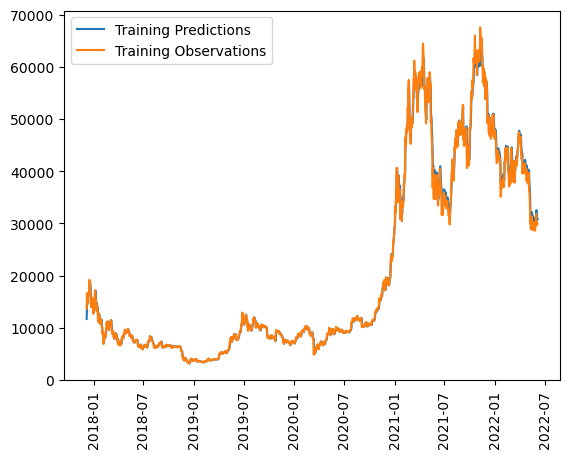

In [21]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [22]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0017310979310423136
Val MAE: 0.029399288818240166


8/8 [==============================] - 0s 9ms/step


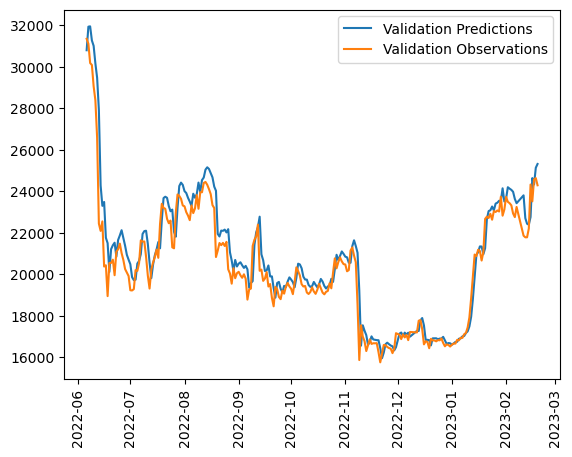

In [23]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [24]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0013954360038042068
Test MAE: 0.03306636959314346


In [25]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 9ms/step
R2 Score:  0.8113546190000847


7/7 [==============================] - 0s 8ms/step


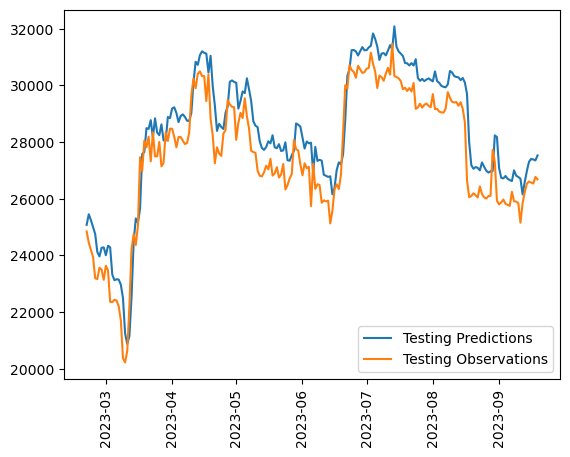

In [26]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [27]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.Bidirectional(LSTM(64)),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
52/52 [==============================] - 7s 41ms/step - loss: 23.9166 - mean_absolute_error: 3.7622 - val_loss: 0.5677 - val_mean_absolute_error: 0.7420
Epoch 2/200
52/52 [==============================] - 1s 29ms/step - loss: 0.7564 - mean_absolute_error: 0.7325 - val_loss: 0.1523 - val_mean_absolute_error: 0.3682
Epoch 3/200
52/52 [==============================] - 1s 21ms/step - loss: 0.6371 - mean_absolute_error: 0.7022 - val_loss: 0.0578 - val_mean_absolute_error: 0.2088
Epoch 4/200
52/52 [==============================] - 1s 21ms/step - loss: 0.3192 - mean_absolute_error: 0.4517 - val_loss: 0.1677 - val_mean_absolute_error: 0.3946
Epoch 5/200
52/52 [==============================] - 1s 28ms/step - loss: 0.0398 - mean_absolute_error: 0.1548 - val_loss: 0.1306 - val_mean_absolute_error: 0.3358
Epoch 6/200
52/52 [==============================] - 1s 29ms/step - loss: 0.0239 - mean_absolute_error: 0.1210 - val_loss: 0.0238 - val_mean_absolute_error: 0.1152
Epoch 7/200
52/

Epoch 51/200
52/52 [==============================] - 1s 23ms/step - loss: 0.0085 - mean_absolute_error: 0.0713 - val_loss: 0.0044 - val_mean_absolute_error: 0.0456
Epoch 52/200
52/52 [==============================] - 1s 26ms/step - loss: 0.0075 - mean_absolute_error: 0.0676 - val_loss: 0.0043 - val_mean_absolute_error: 0.0456
Epoch 53/200
52/52 [==============================] - 1s 26ms/step - loss: 0.0071 - mean_absolute_error: 0.0654 - val_loss: 0.0066 - val_mean_absolute_error: 0.0603
Epoch 54/200
52/52 [==============================] - 1s 26ms/step - loss: 0.0099 - mean_absolute_error: 0.0786 - val_loss: 0.0045 - val_mean_absolute_error: 0.0475
Epoch 55/200
52/52 [==============================] - 1s 28ms/step - loss: 0.0072 - mean_absolute_error: 0.0661 - val_loss: 0.0061 - val_mean_absolute_error: 0.0597
Epoch 56/200
52/52 [==============================] - 2s 47ms/step - loss: 0.0068 - mean_absolute_error: 0.0641 - val_loss: 0.0148 - val_mean_absolute_error: 0.1076
Epoch 57/2

Epoch 101/200
52/52 [==============================] - 1s 23ms/step - loss: 0.0055 - mean_absolute_error: 0.0584 - val_loss: 0.0025 - val_mean_absolute_error: 0.0338
Epoch 102/200
52/52 [==============================] - 1s 26ms/step - loss: 0.0043 - mean_absolute_error: 0.0514 - val_loss: 0.0022 - val_mean_absolute_error: 0.0310
Epoch 103/200
52/52 [==============================] - 1s 27ms/step - loss: 0.0048 - mean_absolute_error: 0.0533 - val_loss: 0.0021 - val_mean_absolute_error: 0.0304
Epoch 104/200
52/52 [==============================] - 1s 26ms/step - loss: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0021 - val_mean_absolute_error: 0.0300
Epoch 105/200
52/52 [==============================] - 1s 27ms/step - loss: 0.0053 - mean_absolute_error: 0.0575 - val_loss: 0.0019 - val_mean_absolute_error: 0.0290
Epoch 106/200
52/52 [==============================] - 1s 23ms/step - loss: 0.0038 - mean_absolute_error: 0.0471 - val_loss: 0.0039 - val_mean_absolute_error: 0.0539
Epoc

52/52 [==============================] - 1s 21ms/step - loss: 0.0041 - mean_absolute_error: 0.0500 - val_loss: 0.0033 - val_mean_absolute_error: 0.0461
Epoch 151/200
52/52 [==============================] - 1s 21ms/step - loss: 0.0044 - mean_absolute_error: 0.0515 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311
Epoch 152/200
52/52 [==============================] - 1s 21ms/step - loss: 0.0050 - mean_absolute_error: 0.0560 - val_loss: 0.0074 - val_mean_absolute_error: 0.0783
Epoch 153/200
52/52 [==============================] - 1s 21ms/step - loss: 0.0040 - mean_absolute_error: 0.0490 - val_loss: 0.0052 - val_mean_absolute_error: 0.0635
Epoch 154/200
52/52 [==============================] - 1s 21ms/step - loss: 0.0029 - mean_absolute_error: 0.0402 - val_loss: 0.0016 - val_mean_absolute_error: 0.0269
Epoch 155/200
52/52 [==============================] - 1s 21ms/step - loss: 0.0040 - mean_absolute_error: 0.0492 - val_loss: 0.0021 - val_mean_absolute_error: 0.0348
Epoch 156/200
52/5

52/52 [==============================] - 1s 23ms/step - loss: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0082 - val_mean_absolute_error: 0.0861
Epoch 200/200
52/52 [==============================] - 1s 21ms/step - loss: 0.0032 - mean_absolute_error: 0.0436 - val_loss: 0.0016 - val_mean_absolute_error: 0.0278


52/52 [==============================] - 1s 6ms/step


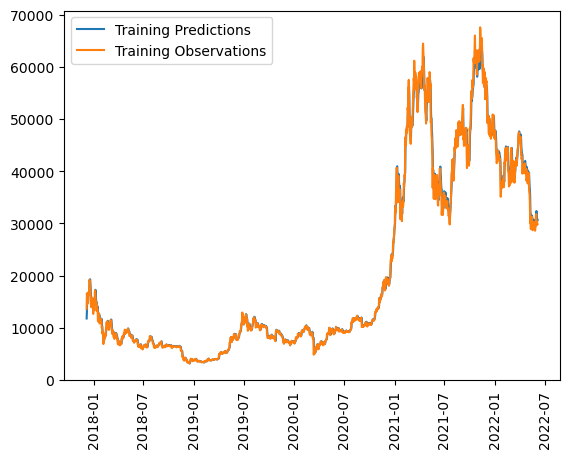

In [28]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [29]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.001572954934090376
Val MAE: 0.027845771983265877


8/8 [==============================] - 0s 10ms/step


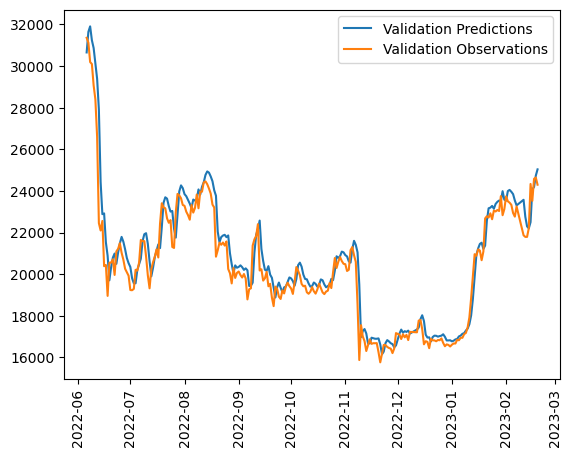

In [30]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [31]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0010773050598800182
Test MAE: 0.027597468346357346


7/7 [==============================] - 0s 7ms/step


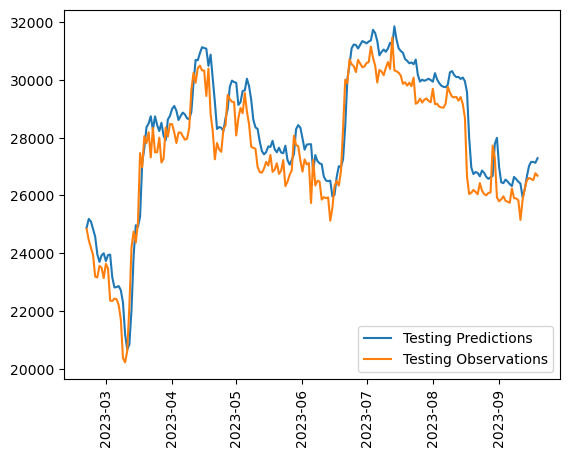

In [32]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [33]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.8543621825720582


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [37]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 30


#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, 30, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, 30, 1))

#add dates to last date in dataset for future predictions   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 123ms/step
[10.192691, 10.192995, 10.193086, 10.192887, 10.192901, 10.192914, 10.192933, 10.192934, 10.192976, 10.192191, 10.191981, 10.192337, 10.192401, 10.192388, 10.192344, 10.192409, 10.192465, 10.19254, 10.192349, 10.192462, 10.192491, 10.192561, 10.193008, 10.192951, 10.192911, 10.192839, 10.192817, 10.192843, 10.192886, 10.192839]
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25
2023-09-26
2023-09-27
2023-09-28
2023-09-29
2023-09-30
2023-10-01
2023-10-02
2023-10-03
2023-10-04
2023-10-05
2023-10-06
2023-10-07
2023-10-08
2023-10-09
2023-10-10
2023-10-11
2023-10-12
2023-10-13
2023-10-14
2023-10-15
2023-10-16
2023-10-17
2023-10-18
2023-10-19


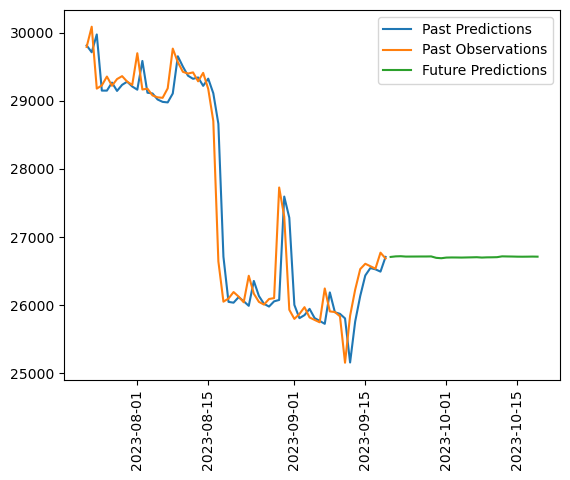

In [39]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [36]:
# Export model1 to HDF5 file
model.save("H5_Files/btc_30_day_1.h5")

In [50]:
# Export model2 to HDF5 file
model2.save("H5_Files/btc_30_day_2.h5")

In [51]:
# Export model to HDF5 file
model3.save("H5_Files/btc_30_day_3.h5")

In [52]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-20,28315.0,28458.949219,27319.105469,27045.462891
2023-06-21,30009.0,29961.904297,28638.505859,28491.263672
2023-06-22,29889.0,31730.695312,30247.191406,30260.552734
2023-06-23,30716.0,31726.822266,30358.310547,30344.648438
2023-06-24,30548.0,32556.482422,31097.568359,31054.771484
...,...,...,...,...
2023-09-14,26529.0,27830.230469,26689.718750,26431.203125
2023-09-15,26607.0,28144.914062,26993.515625,26758.074219
2023-09-16,26571.0,28241.656250,27101.957031,26861.621094


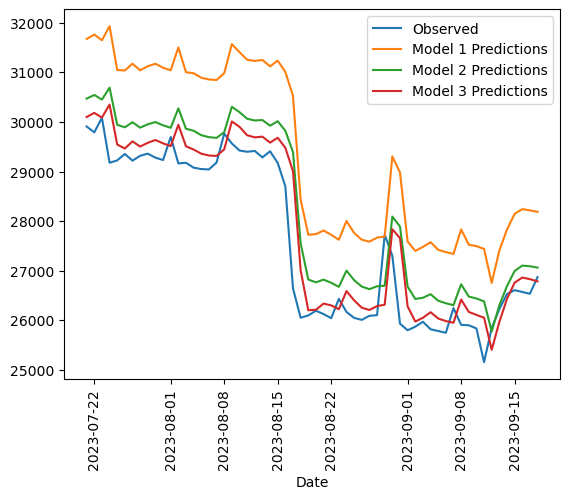

In [53]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [57]:
#output prediction data to csv
df.to_csv('output/btc_predict_30.csv') 

In [55]:
#output original historical data to csv
data.to_csv('output/btc_lifetime_30.csv')

In [56]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.8879186684791553
Model 2 R2 Score:  0.8799552124135969
Model 3 R2 Score:  0.9218392529406312
